In [1]:
# Wij gaan eerst de words.db database opzetten, waarin alle woorden komen op de volgende manier:

# Table words: file_id, index_of_word_of_document, word
# Table file_names: id, file_name
# Table characters: file_id, ongelakte_characters, ongelakt_en_ongelakte_characters

# Voor het gebruiken van de sqllite library
import sqlite3
# Voor het verwijderen van bestanden OS importeren
import os 

# Eerst de huidige database & andere bestanden die bij deze notebook horen verwijderen als die bestaat zodat je alles
# opnieuw kunt uitvoeren
try:
    os.remove("words.db")
    os.remove("words.csv")
except Exception as ex:
    print("Could not remove file")

# Het pad aanpassen waar al je bestanden staan m.b.t. de pdf's.
DATA_PATH = os.getcwd()+'/test/'

con = sqlite3.connect('words.db')
cur = con.cursor()
cur.execute("CREATE TABLE words (file_id int, row int, word text)")
cur.execute("CREATE TABLE file_names (id int, file_name text)")
cur.execute('CREATE TABLE characters (file_id int, ongelakte_characters int, ongelakt_en_ongelakte_characters int)')

In [2]:
# Wij gaan nu eerst de words table vullen met alle woorden uit het document, dit doen wij door alle text uit de .PDF te halen
# en vervolgens in een .CSV bestand te zetten, deze .CSV data zetten wij vervolgens weer in een database de table words
# m.b.v. deze methods kunnen wij dus de words table vullen.

# Deze import is nodig voor het lezen van de CSV bestanden
import csv

def reset_csv():
    with open('words.csv', 'w', encoding='utf-8') as f:
        text = 'Document Naam', 'Woorden'
        writer = csv.writer(f)
        writer.writerow(text)
        
def extract_pdf():
    for filename in glob.glob(os.path.join(DATA_PATH, '*.pdf')):
        pdf_file = open(filename, 'rb')
        pdf_reader = PdfFileReader(pdf_file)
        text = str(os.path.basename(filename)) + ' '

        for num in range(0, pdf_reader.numPages):
            page = pdf_reader.getPage(num)
            text += page.extractText()
        print("extracted "+str(pdf_reader.numPages)+" pages from "+os.path.basename(filename))
        pdf_file.close()
        create_csv_file(text)
    print('done.')
    
def create_csv_file(text):
    with open('words.csv', 'a', encoding='utf-8') as f:

        text = clean_data(text)
        writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(text)
        f.close()


def clean_data(data):
    # these chars will be removed from the text
    to_delete = (".", ",", ";", ":", "/", "\\", "-")
    # these chars will be replaced by a whitespace
    to_replace = ("\n", "(", ")")

    for char in to_delete:
        data = data.replace(char, '')

    for char in to_replace:
        data = data.replace(char, ' ')

    data = data.split()

    while " " in data:
        data.remove(" ")

    return data

In [3]:
# Nu het uitvoeren van deze methodes/functies

# Global path e.d.
import glob
# PDF reader
from PyPDF2 import PdfFileReader

try:
    reset_csv()
    extract_pdf()
except Exception as e:
    print("Could not do a file",e)

extracted 1 pages from 0001.pdf
extracted 2 pages from 0002.pdf
extracted 2 pages from 0004.pdf
extracted 2 pages from 0005.pdf
extracted 1 pages from 0006.pdf
extracted 1 pages from 0007.pdf
extracted 1 pages from 0010.pdf
extracted 1 pages from 0017.pdf
extracted 1 pages from 0018.pdf
extracted 9 pages from 0020.pdf
extracted 1 pages from 0021.pdf
extracted 1 pages from 0022.pdf
extracted 3 pages from 0024.pdf
extracted 9 pages from 0027.pdf
extracted 3 pages from 0028.pdf
extracted 2 pages from 0032.pdf
extracted 2 pages from 0033.pdf
extracted 2 pages from 0033a.pdf
extracted 1 pages from 0034.pdf
extracted 1 pages from 0035.pdf
extracted 3 pages from 0036.pdf
extracted 1 pages from 0037.pdf
extracted 8 pages from 0038.pdf
extracted 1 pages from 0039.pdf
extracted 6 pages from 0040.pdf
extracted 4 pages from 0041.pdf
extracted 4 pages from 0042.pdf
extracted 2 pages from 0043.pdf
extracted 4 pages from 0044.pdf
extracted 10 pages from 0045.pdf
extracted 1 pages from 0046.pdf
extrac

In [4]:
# Nu alle data hiervan die in de .CSV zijn gezet in een database zetten, in de tabel words, maar ook alle file_names in een
# tabel zetten, zodaar wij daar naartoe kunnen verwijzen met een foreign key.

document_map = {}
i = 0
with open('words.csv','r', encoding='utf-8') as person_table:
    dr = csv.DictReader(person_table, delimiter=',')
    for woorden in dr:
        index = 0
        document_naam = woorden['Document Naam']
        if (None in woorden):
            for woord in woorden[None]:
                index = index + 1
                if document_naam not in document_map:
                    i +=1
                    document_map[document_naam] = i
                to_db = (i, index, woord)
                cur.execute("INSERT INTO words VALUES (?, ?, ?)", to_db)
con.commit()
print("Successfully inserted into database")

for k, v in document_map.items():
    cur.execute("INSERT INTO file_names VALUES (?,?)", (v,k))
    print(k)    
con.commit()

Successfully inserted into database
0001pdf
0002pdf
0004pdf
0005pdf
0006pdf
0007pdf
0010pdf
0017pdf
0018pdf
0020pdf
0021pdf
0022pdf
0024pdf
0027pdf
0028pdf
0032pdf
0033pdf
0033apdf
0034pdf
0035pdf
0036pdf
0037pdf
0039pdf
0040pdf
0041pdf
0042pdf
0043pdf
0044pdf
0045pdf
0046pdf
0047pdf
0048pdf
0051pdf
0053pdf
0053apdf
0054pdf
0055pdf


In [5]:
# Het berekenen van het aantal chars per document zonder gelakt, dus het aantal ongelakte characters

# Importeren van libraries
import os
import PyPDF2

txt = {}

# Alle pdfs in de map DATA_PATH met als eindnaam .pdf
pdfs = [f for f in os.listdir(DATA_PATH) if f.lower().endswith('.pdf')]

# De hoeveelheid van alle pdfs die gevonden zijn
n = len(pdfs)
for idx, f in enumerate(pdfs):
    
    with open(DATA_PATH+"/"+f, 'rb') as pf:
        try:
            _total_chars_this_document = 0
            read_pdf = PyPDF2.PdfFileReader(pf)
            for pag in range(read_pdf.getNumPages()):
                _total_chars_this_document = _total_chars_this_document + len(read_pdf.getPage(pag).extractText())
            file_name_without_dot_beceause_not_stored_in_database_with_a_dot = f.replace(".","");
        except Exception as e:
            print("Error",e)
        try:
            print("looking for file name",file_name_without_dot_beceause_not_stored_in_database_with_a_dot,"in database")
            cur.execute("SELECT * FROM file_names WHERE file_name LIKE '"+file_name_without_dot_beceause_not_stored_in_database_with_a_dot+"'")
            for row in cur:
                file_id = row[0]
                print(file_id)
                insert = (file_id, _total_chars_this_document, -1)
                cur.execute("INSERT INTO characters VALUES(?, ?, ?)", insert)
                print(insert)
        except Exception as e:
            print("could not find file_id by name",file_name_without_dot_beceause_not_stored_in_database_with_a_dot)
        
        

looking for file name 0001pdf in database
1
(1, 1166, -1)
looking for file name 0002pdf in database
2
(2, 993, -1)
looking for file name 0004pdf in database
3
(3, 1139, -1)
looking for file name 0005pdf in database
4
(4, 302, -1)
looking for file name 0006pdf in database
5
(5, 618, -1)
looking for file name 0007pdf in database
6
(6, 1610, -1)
looking for file name 0010pdf in database
7
(7, 660, -1)
looking for file name 0017pdf in database
8
(8, 754, -1)
looking for file name 0018pdf in database
9
(9, 1013, -1)
looking for file name 0020pdf in database
10
(10, 8362, -1)
looking for file name 0021pdf in database
11
(11, 767, -1)
looking for file name 0022pdf in database
12
(12, 1010, -1)
looking for file name 0024pdf in database
13
(13, 360, -1)
looking for file name 0027pdf in database
14
(14, 1494, -1)
looking for file name 0028pdf in database
15
(15, 4022, -1)
looking for file name 0032pdf in database
16
(16, 3250, -1)
looking for file name 0033pdf in database
17
(17, 1073, -1)
looki

In [6]:
# Het totale aantal character is berekend door Gert Jacobusse op RWS locatie, dus wij kunnen nu berekenen hoeveel gelakt is
# m.b.v. deze data, want totale characters = ongelakt + gelakt

# Dit kan worden vertaald naar: gelakt = totale characters - ongelakt
# Gert Jacobusse heeft dit gedocumenteerd in een .txt met het volgende:

# getal van de iteratie, percentage compleet met de iteratie, bestandnaam, totale aantal characters

gelakt = {}
with open('chars_ongelakt_1.txt', 'r') as f:
    for line in f:
        params = line.split(" ")
        name_start = line.index(params[2])
        name_end = line.index('pdf')
        name = line[name_start:(name_end+3)]
        gelakt[name] = params[len(params)-1].replace('\n', '')
        
        file_name_without_dot_beceause_not_stored_in_database_with_a_dot = name.replace(".","");
        try:
            cur.execute("SELECT * FROM file_names WHERE file_name LIKE '"+file_name_without_dot_beceause_not_stored_in_database_with_a_dot+"'")
            for row in cur:
                print(name, row[0], gelakt[name])
                cur.execute("UPDATE characters SET ongelakt_en_ongelakte_characters="+gelakt[name]+" WHERE file_id='"+str(row[0])+"'")
                print("updated characters in file",file_name_without_dot_beceause_not_stored_in_database_with_a_dot,"with",gelakt[name])
        except Exception as e:
            print("could not find file_id by name in database",file_name_without_dot_beceause_not_stored_in_database_with_a_dot)
            
with open('chars_ongelakt_2.txt', 'r') as f:
    for line in f:
        params = line.split(" ")
        name_start = line.index(params[2])
        try:
            name_end = line.index('pdf')
        except(ValueError):
            name_end = line.index("PDF")
        name = line[name_start:(name_end+3)]
        gelakt[name] = params[len(params)-1].replace('\n', '')
        
        file_name_without_dot_beceause_not_stored_in_database_with_a_dot = name.replace(".","");
        try:
            cur.execute("SELECT * FROM file_names WHERE file_name LIKE '"+file_name_without_dot_beceause_not_stored_in_database_with_a_dot+"'")
            for row in cur:
                print(name, row[0], gelakt[name])
                cur.execute("UPDATE characters SET ongelakt_en_ongelakte_characters="+gelakt[name]+" WHERE file_id='"+str(row[0])+"'")
                print("updated characters in file",file_name_without_dot_beceause_not_stored_in_database_with_a_dot,"with",gelakt[name])
        except Exception as e:
            print("could not find file_id by name in database",file_name_without_dot_beceause_not_stored_in_database_with_a_dot)

could not find file_id by name in database 0697 Bijlage 1 Memo scenario's Rhibs v 12pdf
could not find file_id by name in database 0971 - VTW op POF huur Rhib's Kossen en overeenstemming met Kossen over de huurprijs en modificatie 1 x nieuw te bouwen huur Rhibpdf
could not find file_id by name in database 0608-Overzicht contractwijzigingen zaak 310984510001 RHIB's BBpdf
could not find file_id by name in database 0977 - VTW-Advies en vaareigenschappen RHIB's concept 30 mei 2017pdf
could not find file_id by name in database 852 - FW  Herziene besluitvorming tav de RHIB's Barend Biesheuvel (22)pdf
could not find file_id by name in database 847 - FW  Gunning opdracht aan MARIN  begeleiding en rapportage validatie ARIMAR RHIB'spdf
0048.pdf 32 3737
updated characters in file 0048pdf with 3737
could not find file_id by name in database 0970 - Vorige aanbestedingen mbt RHIB's en contact gegevens Arimarpdf
could not find file_id by name in database 877 - FW  Rhib's update (6)pdf
could not find 

could not find file_id by name in database 1599 - Aanbiedingsbrief geluids- en trillingmetingen RHIB'spdf
could not find file_id by name in database 1749 - OMO-B-524 Builder's Plate 850 EFB DCG (codMC6209771) rev 1pdf
could not find file_id by name in database 1723 - VTW's MED Rhibspdf
could not find file_id by name in database 1421 - Scenario 5 Rhib's Arimar - Contract      (nâˆ‚Â¯31098451)pdf
could not find file_id by name in database 1493 - ter info en check Decision about the rhib'spdf
could not find file_id by name in database 1460 - Decision about the rhib'spdf
could not find file_id by name in database 1541 - FYI besluit memo RHIB's Barend Biesheuvelpdf
could not find file_id by name in database 1931 - Memo scenario's Rhibs WvGpdf
could not find file_id by name in database 1514 - Offerteaanvraag advies eisen vaareigenschappen RHIB'spdf
could not find file_id by name in database 1489 - ter info en check Decision about the rhib'spdf
could not find file_id by name in database 1294 

In [7]:
# Nu is het kijken of het is ingevoerd in je database

# words tabel
print("woorden in database")
cur.execute("SELECT * FROM words LIMIT 2")
for row in cur:
    print(row)
    
# file_names tabel
print("betands namen in database")
cur.execute("SELECT * FROM file_names LIMIT 2")
for row in cur:
    print(row)
    
# characters tabel
print("characters in database waarin totaal/ongelakte in staan")
cur.execute("SELECT * FROM characters LIMIT 2")
for row in cur:
    print(row)
    
        
# % gelakte
print("gelakte hoeveelheid")
sql = ("SELECT * FROM (SELECT *, ROUND((CAST(ongelakt_en_ongelakte_characters-ongelakte_characters AS float))/(CAST(ongelakt_en_ongelakte_characters AS float)),4) * 100 as gelakt_percentage FROM characters WHERE ongelakt_en_ongelakte_characters > 0 AND ongelakt_en_ongelakte_characters > 0 LIMIT 100) as p ORDER BY p.gelakt_percentage DESC")
cur.execute(sql)
for row in cur:
    print(row)

woorden in database
(1, 1, 'PPO')
(1, 2, 'Verzonden')
betands namen in database
(1, '0001pdf')
(2, '0002pdf')
characters in database waarin totaal/ongelakte in staan
(1, 1166, 1481)
(2, 993, 5857)
gelakte hoeveelheid
(24, 80, 16172, 99.51)
(13, 360, 8329, 95.67999999999999)
(26, 538, 9757, 94.49)
(14, 1494, 23965, 93.77)
(18, 307, 3147, 90.24)
(36, 537, 4955, 89.16)
(4, 302, 2702, 88.82)
(2, 993, 5857, 83.05)
(31, 969, 4228, 77.08)
(32, 1036, 3737, 72.28)
(12, 1010, 3476, 70.94)
(28, 2607, 8585, 69.63000000000001)
(3, 1139, 3552, 67.93)
(17, 1073, 3194, 66.41)
(37, 1125, 3322, 66.13)
(30, 916, 2623, 65.08)
(7, 660, 1793, 63.190000000000005)
(10, 8362, 21594, 61.28)
(23, 1252, 2829, 55.74)
(25, 4071, 8981, 54.669999999999995)
(9, 1013, 2182, 53.56999999999999)
(19, 864, 1807, 52.190000000000005)
(11, 767, 1353, 43.309999999999995)
(21, 2545, 4026, 36.79)
(20, 738, 1115, 33.81)
(5, 618, 914, 32.39)
(16, 3250, 4762, 31.75)
(8, 754, 1101, 31.52)
(33, 2086, 2765, 24.560000000000002)
(22, 17

0 24 Rijksrederij 56.36124999999999
1 31 de 54.99483870967741
2 26 het 54.71961538461538
3 29 2016 54.62137931034483
4 21 voor 53.6195238095238
5 31 ZD 53.55483870967741
6 32 Aan 53.512187499999996
7 32 Onderwerp 53.512187499999996
8 32 Verzonden 53.512187499999996
9 24 CC 53.21
10 32 en 52.93562499999999
11 23 34 52.88347826086956
12 21 te 52.85142857142856
13 23 Arimar 52.535217391304336
14 23 Delta 51.79782608695652
15 23 Zee 51.79782608695652
16 26 Rijkswaterstaat 51.22730769230769
17 21 Postbus 51.07999999999999
18 22 Kleiweg 50.99227272727273
19 28 van 50.796785714285704


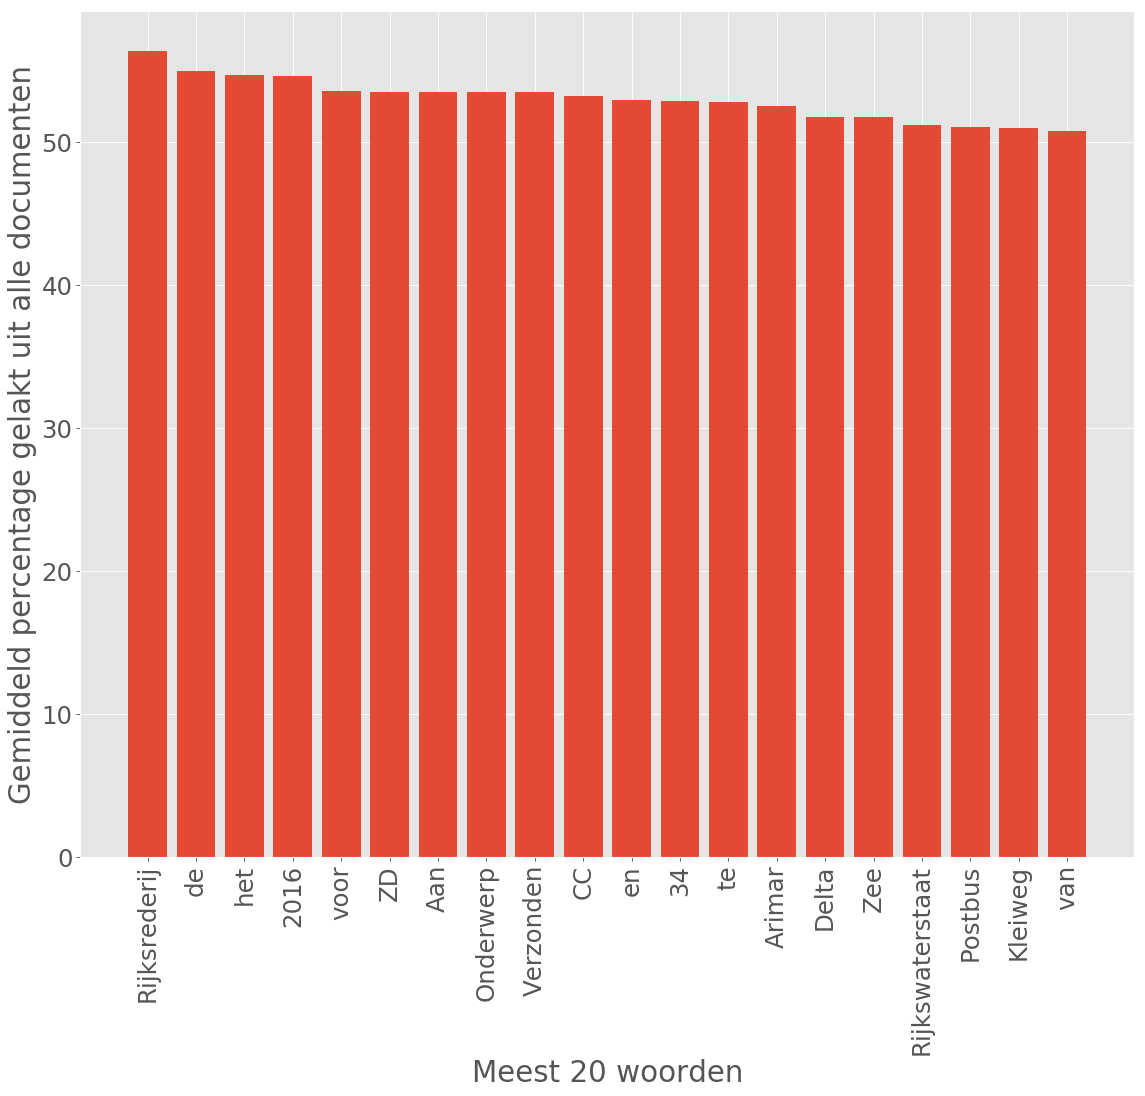

In [8]:
# Nu willen wij een model gaan maken op het volgende:
# Bij welke woorden is er een hoge kans dat het document gelakt is?

# Eest alle woorden pakken, dan grouperen op file_id, dan de percentages erbij joinen
# Dan de gemiddelde van deze uitrekenen

# Laatste versie van query
sql = ("SELECT * FROM (SELECT COUNT(*) as resultaat_uit_hoeveelheid_bestanden, results.word, AVG(results.gelakt_percentage) as gelakt_percentage FROM (SELECT words.word, words.file_id, (ROUND((CAST(c.ongelakt_en_ongelakte_characters-c.ongelakte_characters AS FLOAT))/(CAST(c.ongelakt_en_ongelakte_characters AS FLOAT)),4) * 100) AS gelakt_percentage FROM (SELECT COUNT(*), w.word, w.file_id FROM words AS w  GROUP BY w.word, w.file_id) as words LEFT JOIN file_names AS fn ON fn.id=words.file_id LEFT JOIN characters AS c ON c.file_id=words.file_id ORDER BY gelakt_percentage DESC) as results WHERE results.gelakt_percentage IS NOT NULL AND results.gelakt_percentage > 0 AND results.gelakt_percentage <= 100 GROUP BY results.word) as total WHERE LENGTH(total.word) <  30 AND  total.resultaat_uit_hoeveelheid_bestanden > 20 ORDER BY total.gelakt_percentage DESC LIMIT 20")
cur.execute(sql)

hoeveel = []
words = []
gelakt = []
index = 0
# De inhoud
for row in cur:
    print(index, row[0], row[1], row[2])
    hoeveel.append(row[0])
    words.append(row[1])
    gelakt.append(row[2])
    index = index + 1
    
# De headers
cur.description

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from matplotlib.pyplot import figure
figure(num=None, figsize=(17, 14), dpi=80, facecolor='w', edgecolor='k')

plt.rcParams.update({'font.size': 22})
plt.bar(words, gelakt)
plt.xticks(rotation=90)
plt.ylabel('Gemiddeld percentage gelakt uit alle documenten')
plt.xlabel('Meest 20 woorden')
plt.show()

0 23 met 46.95739130434782
1 22 een 49.15045454545453
2 23 in 49.50739130434782
3 21 Lange 49.75
4 21 is 50.58666666666665
5 25 PPO 50.77839999999999
6 28 van 50.796785714285704
7 22 Kleiweg 50.99227272727273
8 21 Postbus 51.07999999999999
9 26 Rijkswaterstaat 51.22730769230769
10 23 Delta 51.79782608695652
11 23 Zee 51.79782608695652
12 23 Arimar 52.535217391304336
13 21 te 52.85142857142856
14 23 34 52.88347826086956
15 32 en 52.93562499999999
16 24 CC 53.21
17 32 Aan 53.512187499999996
18 32 Onderwerp 53.512187499999996
19 32 Verzonden 53.512187499999996


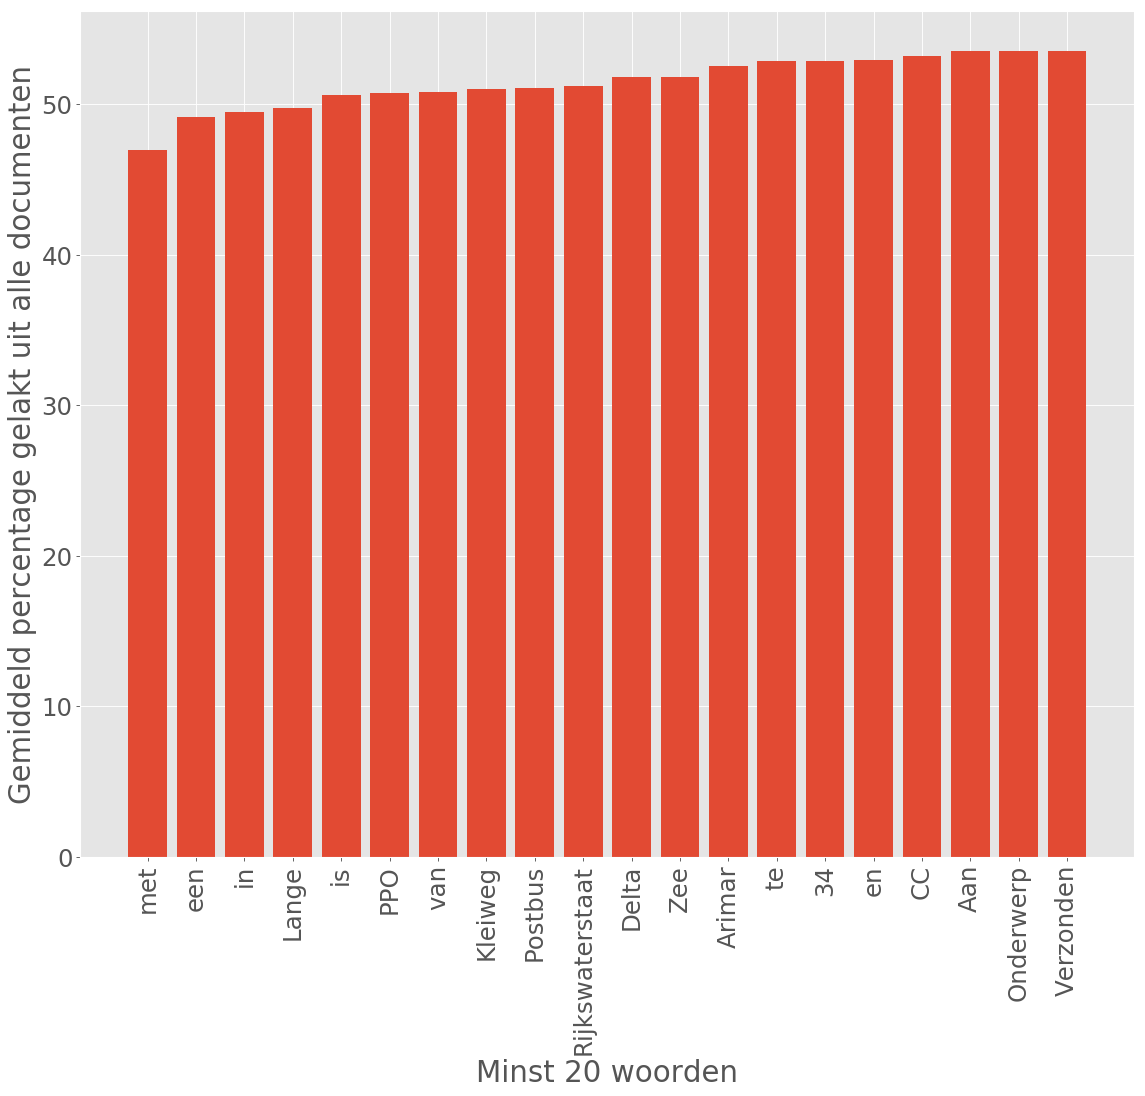

In [9]:
sql = ("SELECT * FROM (SELECT COUNT(*) as resultaat_uit_hoeveelheid_bestanden, results.word, AVG(results.gelakt_percentage) as gelakt_percentage FROM (SELECT words.word, words.file_id, (ROUND((CAST(c.ongelakt_en_ongelakte_characters-c.ongelakte_characters AS FLOAT))/(CAST(c.ongelakt_en_ongelakte_characters AS FLOAT)),4) * 100) AS gelakt_percentage FROM (SELECT COUNT(*), w.word, w.file_id FROM words AS w  GROUP BY w.word, w.file_id) as words LEFT JOIN file_names AS fn ON fn.id=words.file_id LEFT JOIN characters AS c ON c.file_id=words.file_id ORDER BY gelakt_percentage DESC) as results WHERE results.gelakt_percentage IS NOT NULL AND results.gelakt_percentage > 0 AND results.gelakt_percentage <= 100 GROUP BY results.word) as total WHERE LENGTH(total.word) <  30 AND  total.resultaat_uit_hoeveelheid_bestanden > 20 ORDER BY total.gelakt_percentage ASC LIMIT 20")
cur.execute(sql)

hoeveel = []
words = []
gelakt = []
index = 0
# De inhoud
for row in cur:
    print(index, row[0], row[1], row[2])
    hoeveel.append(row[0])
    words.append(row[1])
    gelakt.append(row[2])
    index = index + 1
    
# De headers
cur.description

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from matplotlib.pyplot import figure
figure(num=None, figsize=(17, 14), dpi=80, facecolor='w', edgecolor='k')

plt.rcParams.update({'font.size': 22})
plt.bar(words, gelakt)
plt.xticks(rotation=90)
plt.ylabel('Gemiddeld percentage gelakt uit alle documenten')
plt.xlabel('Minst 20 woorden')
plt.show()

0 23 met 46.95739130434782
1 22 een 49.15045454545453
2 23 in 49.50739130434782
3 21 Lange 49.75
4 21 is 50.58666666666665
5 25 PPO 50.77839999999999
6 28 van 50.796785714285704
7 22 Kleiweg 50.99227272727273
8 21 Postbus 51.07999999999999
9 26 Rijkswaterstaat 51.22730769230769
10 23 Delta 51.79782608695652
11 23 Zee 51.79782608695652
12 23 Arimar 52.535217391304336
13 21 te 52.85142857142856
14 23 34 52.88347826086956
15 32 en 52.93562499999999
16 24 CC 53.21
17 32 Aan 53.512187499999996
18 32 Onderwerp 53.512187499999996
19 32 Verzonden 53.512187499999996
20 31 ZD 53.55483870967741
21 21 voor 53.6195238095238
22 29 2016 54.62137931034483
23 26 het 54.71961538461538
24 31 de 54.99483870967741


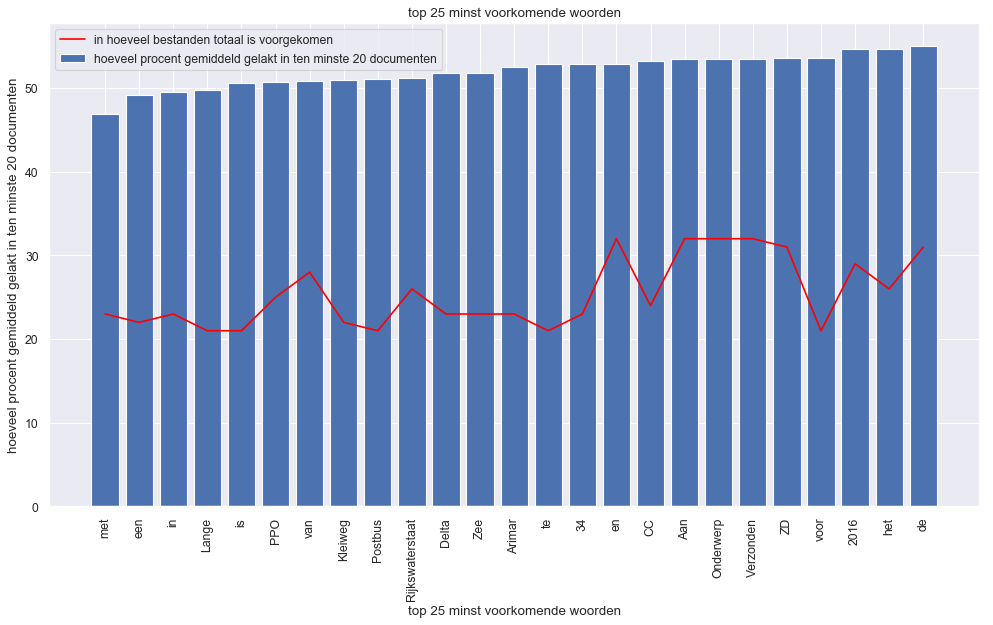

In [10]:
sql = ("SELECT * FROM (SELECT COUNT(*) as resultaat_uit_hoeveelheid_bestanden, results.word, AVG(results.gelakt_percentage) as gelakt_percentage FROM (SELECT words.word, words.file_id, (ROUND((CAST(c.ongelakt_en_ongelakte_characters-c.ongelakte_characters AS FLOAT))/(CAST(c.ongelakt_en_ongelakte_characters AS FLOAT)),4) * 100) AS gelakt_percentage FROM (SELECT COUNT(*), w.word, w.file_id FROM words AS w  GROUP BY w.word, w.file_id) as words LEFT JOIN file_names AS fn ON fn.id=words.file_id LEFT JOIN characters AS c ON c.file_id=words.file_id ORDER BY gelakt_percentage DESC) as results WHERE results.gelakt_percentage IS NOT NULL AND results.gelakt_percentage > 0 AND results.gelakt_percentage <= 100 GROUP BY results.word) as total WHERE LENGTH(total.word) <  30 AND  total.resultaat_uit_hoeveelheid_bestanden > 20 ORDER BY total.gelakt_percentage ASC LIMIT 25")
cur.execute(sql)

hoeveel = []
words = []
gelakt = []
index = 0
# De inhoud
for row in cur:
    print(index, row[0], row[1], row[2])
    hoeveel.append(row[0])
    words.append(row[1])
    gelakt.append(row[2])
    index = index + 1
    
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

# Plot normal and moving average
plt.bar(words, gelakt, label="hoeveel procent gemiddeld gelakt in ten minste 20 documenten")
plt.plot(hoeveel, 'red', label="in hoeveel bestanden totaal is voorgekomen")
plt.xticks(rotation=90)
# plt.plot(period_timeslot, period_growth, label="moving average")
plt.xlabel('top 25 minst voorkomende woorden')
plt.title('top 25 minst voorkomende woorden')
plt.ylabel('hoeveel procent gemiddeld gelakt in ten minste 20 documenten')
plt.grid(True)
plt.legend()
plt.show()


0 24 Rijksrederij 56.36124999999999
1 31 de 54.99483870967741
2 26 het 54.71961538461538
3 29 2016 54.62137931034483
4 21 voor 53.6195238095238
5 31 ZD 53.55483870967741
6 32 Aan 53.512187499999996
7 32 Onderwerp 53.512187499999996
8 32 Verzonden 53.512187499999996
9 24 CC 53.21
10 32 en 52.93562499999999
11 23 34 52.88347826086956
12 21 te 52.85142857142856
13 23 Arimar 52.535217391304336
14 23 Delta 51.79782608695652
15 23 Zee 51.79782608695652
16 26 Rijkswaterstaat 51.22730769230769
17 21 Postbus 51.07999999999999
18 22 Kleiweg 50.99227272727273
19 28 van 50.796785714285704
20 25 PPO 50.77839999999999
21 21 is 50.58666666666665
22 21 Lange 49.75
23 23 in 49.50739130434782
24 22 een 49.15045454545453
25 23 met 46.95739130434782


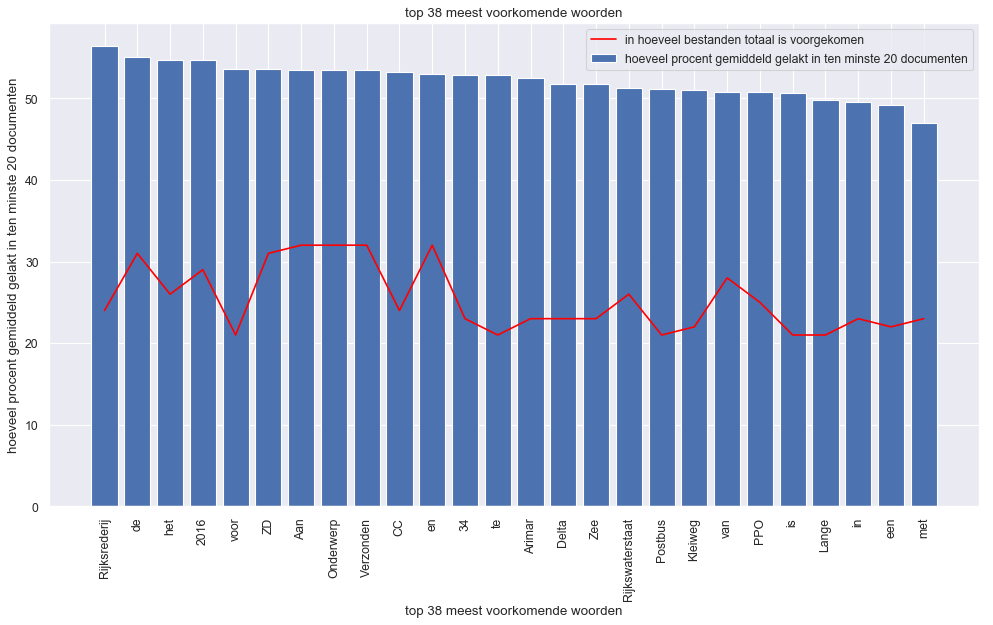

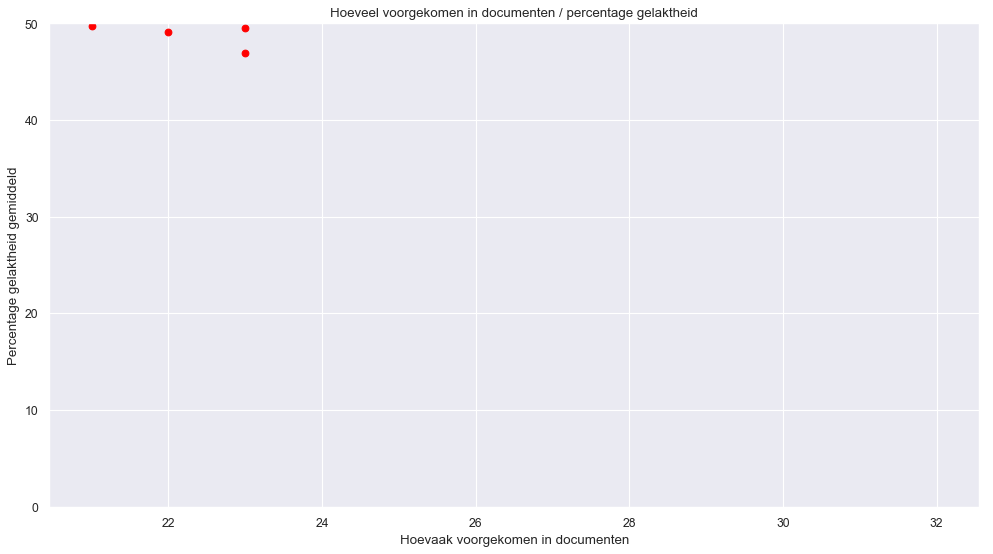

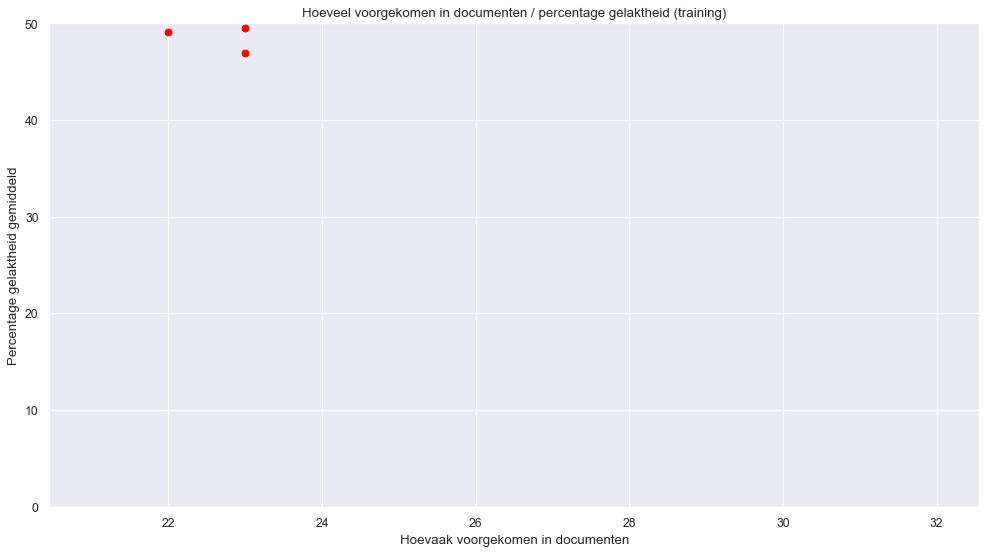

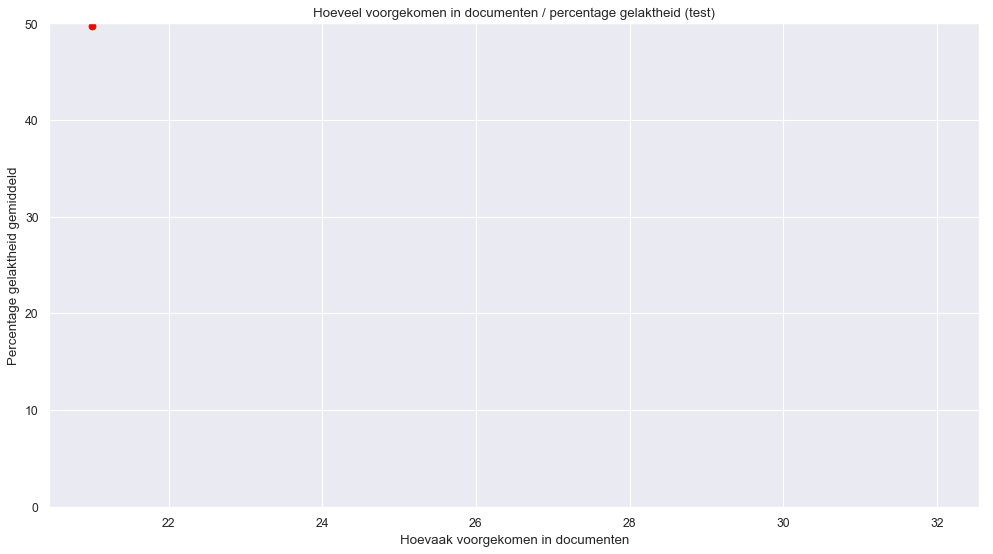

In [11]:
sql = ("SELECT * FROM (SELECT COUNT(*) as resultaat_uit_hoeveelheid_bestanden, results.word, AVG(results.gelakt_percentage) as gelakt_percentage FROM (SELECT words.word, words.file_id, (ROUND((CAST(c.ongelakt_en_ongelakte_characters-c.ongelakte_characters AS FLOAT))/(CAST(c.ongelakt_en_ongelakte_characters AS FLOAT)),4) * 100) AS gelakt_percentage FROM (SELECT COUNT(*), w.word, w.file_id FROM words AS w  GROUP BY w.word, w.file_id) as words LEFT JOIN file_names AS fn ON fn.id=words.file_id LEFT JOIN characters AS c ON c.file_id=words.file_id ORDER BY gelakt_percentage DESC) as results WHERE results.gelakt_percentage IS NOT NULL AND results.gelakt_percentage > 0 AND results.gelakt_percentage <= 100 GROUP BY results.word) as total WHERE LENGTH(total.word) <  30 AND  total.resultaat_uit_hoeveelheid_bestanden > 20 ORDER BY total.gelakt_percentage DESC LIMIT 38")
cur.execute(sql)

hoeveel = []
words = []
gelakt = []
index = 0
# De inhoud
for row in cur:
    print(index, row[0], row[1], row[2])
    hoeveel.append(row[0])
    words.append(row[1])
    gelakt.append(row[2])
    index = index + 1
    
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

# Plot normal and moving average
plt.bar(words, gelakt, label="hoeveel procent gemiddeld gelakt in ten minste 20 documenten")
plt.plot(hoeveel, 'red', label="in hoeveel bestanden totaal is voorgekomen")
plt.xticks(rotation=90)
# plt.plot(period_timeslot, period_growth, label="moving average")
plt.xlabel('top 38 meest voorkomende woorden')
plt.title('top 38 meest voorkomende woorden')
plt.ylabel('hoeveel procent gemiddeld gelakt in ten minste 20 documenten')
plt.grid(True)
plt.legend()
plt.show()


import numpy
import matplotlib.pyplot as plot
import pandas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

x = hoeveel
y = gelakt

x = np.array(x).reshape((-1, 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
linearRegressor = LinearRegression()
linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(x, y, color = 'red')
plot.plot(x, linearRegressor.predict(x), color = 'blue')
plot.ylim(0, 50)
plot.title('Hoeveel voorgekomen in documenten / percentage gelaktheid')
plot.xlabel('Hoevaak voorgekomen in documenten')
plot.ylabel('Percentage gelaktheid gemiddeld')
plot.show()

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(xTrain, yTrain, color = 'red')
plot.plot(xTrain, linearRegressor.predict(xTrain), color = 'blue')
plot.ylim(0, 50)
plot.title('Hoeveel voorgekomen in documenten / percentage gelaktheid (training)')
plot.xlabel('Hoevaak voorgekomen in documenten')
plot.ylabel('Percentage gelaktheid gemiddeld')
plot.show()

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(xTest, yTest, color = 'red')
plot.plot(xTrain, linearRegressor.predict(xTrain), color = 'blue')
plot.ylim(0, 50)
plot.title('Hoeveel voorgekomen in documenten / percentage gelaktheid (test)')
plot.xlabel('Hoevaak voorgekomen in documenten')
plot.ylabel('Percentage gelaktheid gemiddeld')
plot.show()


0 125243 66441


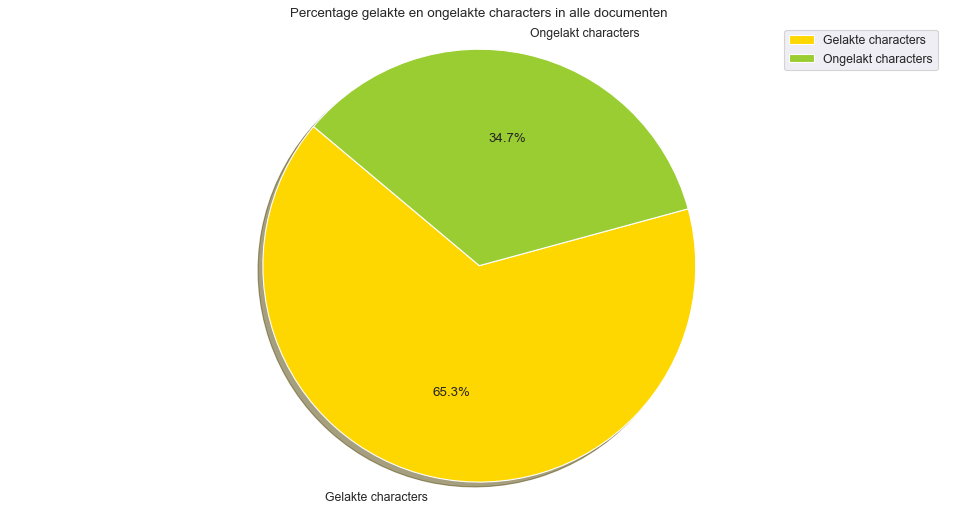

In [12]:
sql = ("SELECT SUM(ongelakt_en_ongelakte_characters) - SUM(ongelakte_characters) as gelakt, SUM(ongelakte_characters) as ongelakt FROM characters")

cur.execute(sql)

totaal_gelakt = []
totaal_ongelakt = []
index = 0

for row in cur:
    print(index, row[0], row[1])
    totaal_gelakt.append(row[0])
    totaal_ongelakt.append(row[1])
    index = index + 1
    
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Gelakte characters', 'Ongelakt characters'
sizes = [totaal_gelakt, totaal_ongelakt]
colors = ['gold', 'yellowgreen']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels, loc="best")
plt.title("Percentage gelakte en ongelakte characters in alle documenten")
 
plt.axis('equal')
plt.show()

# import numpy
# numpy.corrcoef(ongelakt, gelakt)


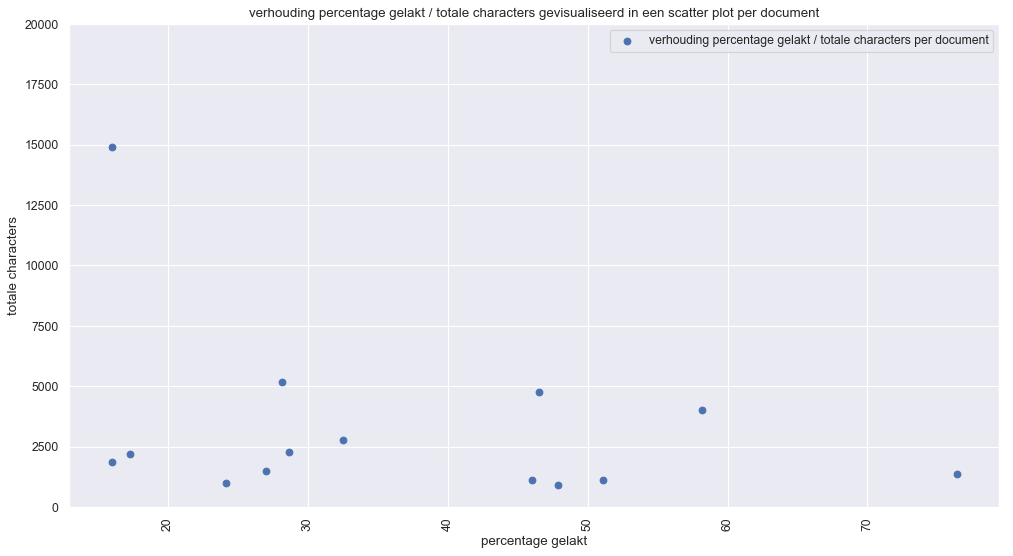

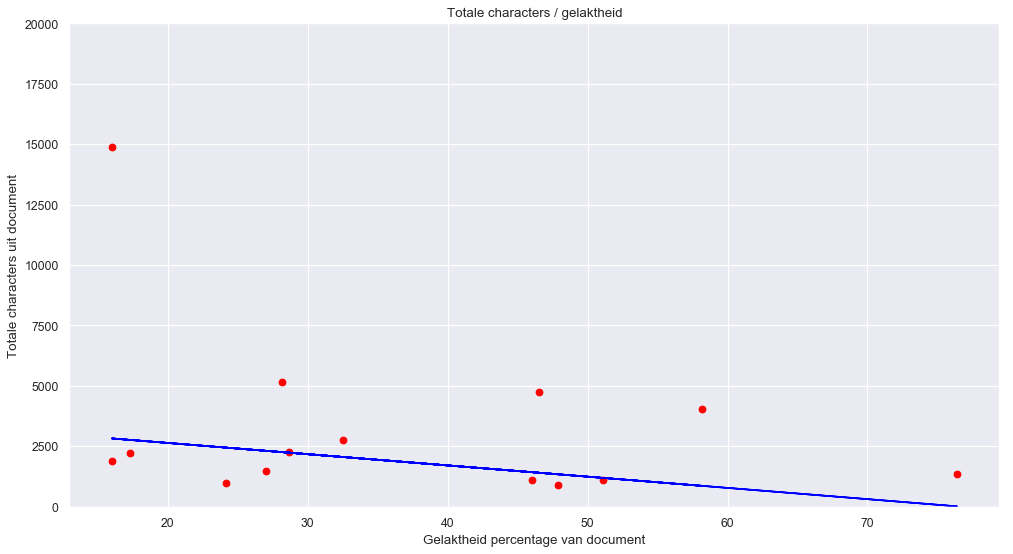

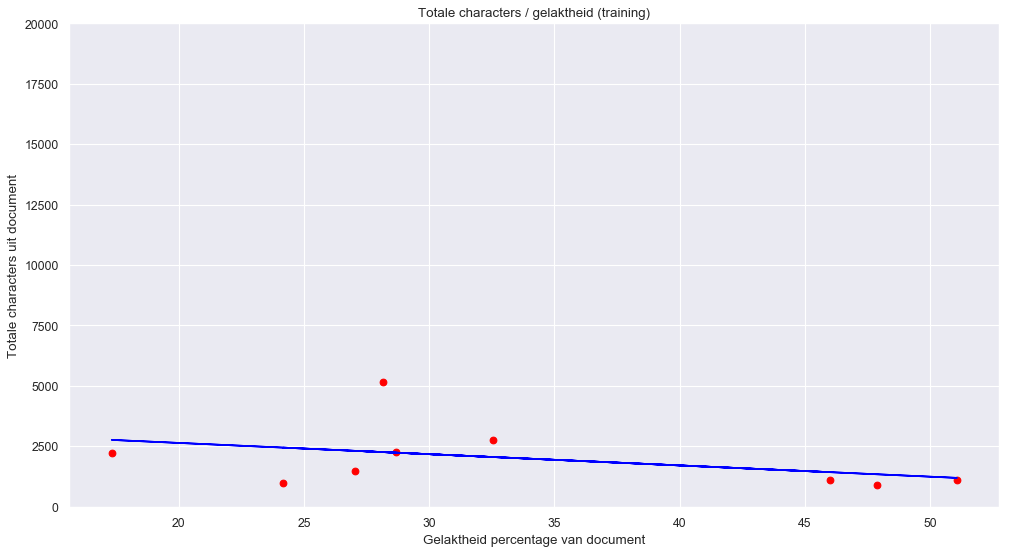

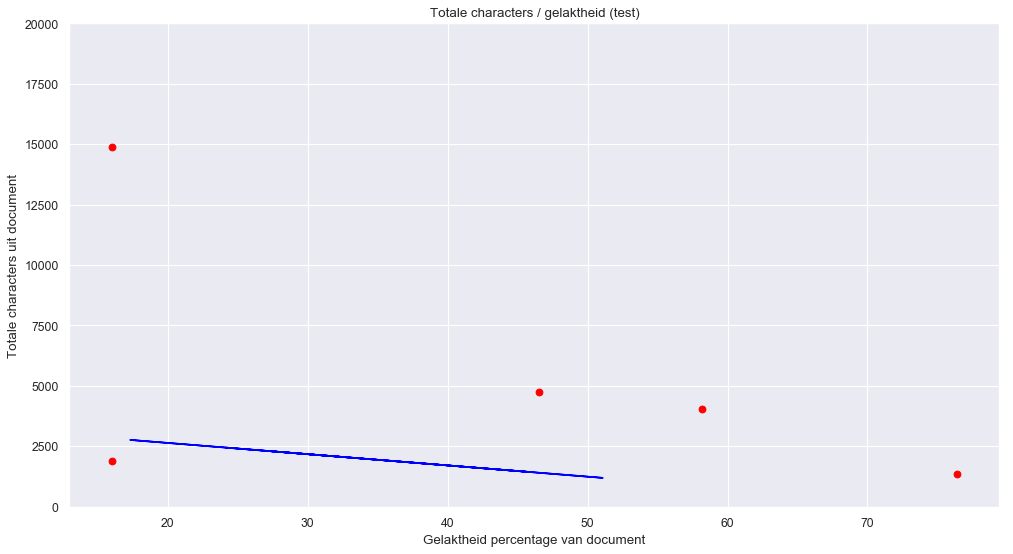

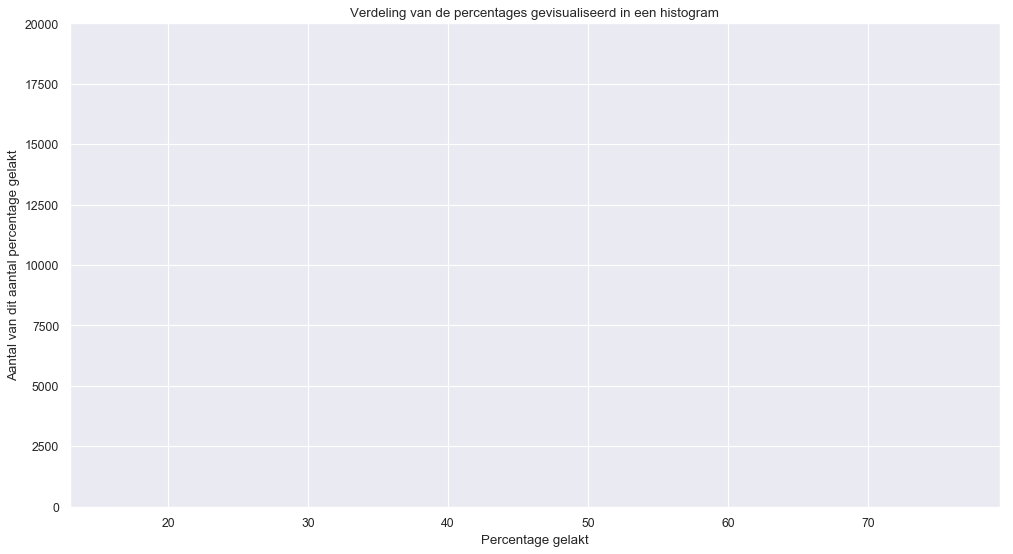

array([[ 1.        , -0.32195881],
       [-0.32195881,  1.        ]])

In [13]:
sql = ("SELECT * FROM (SELECT (CAST(ongelakt_en_ongelakte_characters - ongelakte_characters AS float) / CAST(ongelakte_characters AS float)) * 100 as percentage_gelakt, ongelakt_en_ongelakte_characters as totale_characters FROM characters) as p WHERE p.percentage_gelakt < 100 AND p.percentage_gelakt > 0")

cur.execute(sql)

percentage_gelakt = []
totale_characters = []
index = 0

for row in cur:
    percentage_gelakt.append(row[0])
    totale_characters.append(row[1])
    index = index + 1
    
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

# Plot normal and moving average
plt.scatter(percentage_gelakt, totale_characters, label="verhouding percentage gelakt / totale characters per document")
plt.xticks(rotation=90)
plot.ylim(0, 20000)
plt.xlabel('percentage gelakt')
plt.ylabel('totale characters')
plt.title("verhouding percentage gelakt / totale characters gevisualiseerd in een scatter plot per document")
plt.grid(True)
plt.legend()
plt.show()

import numpy
import matplotlib.pyplot as plot
import pandas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

x = percentage_gelakt
y = totale_characters

x = np.array(x).reshape((-1, 1))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
linearRegressor = LinearRegression()
linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(x, y, color = 'red')
plot.plot(x, linearRegressor.predict(x), color = 'blue')
plot.ylim(0, 20000)
plot.title('Totale characters / gelaktheid')
plot.xlabel('Gelaktheid percentage van document')
plot.ylabel('Totale characters uit document')
plot.show()

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(xTrain, yTrain, color = 'red')
plot.plot(xTrain, linearRegressor.predict(xTrain), color = 'blue')
plot.ylim(0, 20000)
plot.title('Totale characters / gelaktheid (training)')
plot.xlabel('Gelaktheid percentage van document')
plot.ylabel('Totale characters uit document')
plot.show()

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(xTest, yTest, color = 'red')
plot.plot(xTrain, linearRegressor.predict(xTrain), color = 'blue')
plot.ylim(0, 20000)
plot.title('Totale characters / gelaktheid (test)')
plot.xlabel('Gelaktheid percentage van document')
plot.ylabel('Totale characters uit document')
plot.show()

figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.hist(percentage_gelakt)
plot.ylim(0, 20000)
plt.title("Verdeling van de percentages gevisualiseerd in een histogram")
plt.xlabel('Percentage gelakt')
plt.ylabel('Aantal van dit aantal percentage gelakt')
plt.show()

# import numpy
numpy.corrcoef(percentage_gelakt, totale_characters)

In [14]:
# sql = ("SELECT w.totale_woorden_in_alle_documenten / totale_files FROM (SELECT COUNT(*) as totale_woorden_in_alle_documenten, COUNT(DISTINCT(file_id)) as totale_files FROM words) as w")

# cur.execute(sql)

# for row in cur:
#     print(row)

# sql = ("SELECT COUNT(*) FROM words")

# cur.execute(sql)

# for row in cur:
#     print(row)
    
    
# sql = ("UPDATE words SET active = 0")
# cur.execute(sql)
# print("updated")

# sql = ("SELECT COUNT(*) FROM words WHERE active=1")
# cur.execute(sql)

# for row in cur:
#     print(row)


In [15]:
# from urllib.request import urlopen
# from bs4 import BeautifulSoup 

# html = urlopen('http://en.wikipedia.org/wiki/Kevin_Bacon')
# bs = BeautifulSoup(html, 'html.parser')
# for link in bs.find_all('a'):
#     if 'href' in link.attrs:
#         print(link.attrs['href'])

from sqlalchemy import create_engine
import pymysql
import pandas as pd

df2 = pd.read_sql("SELECT * FROM characters", con)
df2.head()

,file_id,ongelakte_characters,ongelakt_en_ongelakte_characters
0,1,1166,1481
1,2,993,5857
2,3,1139,3552
3,4,302,2702
4,5,618,914


In [16]:
import numpy

# words table
doc = []
done = ""

cur.execute("SELECT REPLACE(GROUP_CONCAT(word), ',',' ') FROM words WHERE LENGTH(word) < 10 GROUP BY file_id")
for row in cur:
    row = list(row)
    doc.append(row)
    
for d in doc:
    done += str(d).replace("[","").replace("]","")+","
    
done = done[0:len(done) - 1];
done = done.split(",")[1:-1]

print(len(done))
print(done[0])



35
"ZD Verzonden dinsdag 13 september 2016 2155 Aan ZD ZD ZD ZD CC ZD Onderwerp Advies MT Arimar Beste MTleden Bijgaand het advies naar van vanmorgen in het Basis voor dit advies zijn de stukken van email 20160907 RHIB's Barend en de Indien gewenst geef ik graag mondeling nog een groet 2 Zee en Delta | Lange Kleiweg 34 Rijswijk | Postbus 5807 2280 HV Rijswijk M Water Wegen Werken"


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy

# for x in range(20):
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(done)

true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")


Y = vectorizer.transform(["Van: Verzonden: maandag 29 mei 2017 16:45 Aan: ) Onderwerp: FW: Validatie Arimar Rhibs - commitment gevraagd Urgentie: Hoog Van: PO) Verzonden: woensdag 24 mei 2017 22:24 Aan: ) Onderwerp: FW: Validatie Arimar Rhibs - commitment gevraagd Urgentie: Hoog Ter info. Van: Verzonden: woensdag 24 mei 2017 22:21 Aan: CC: Onderwerp: Validatie Arimar Rhibs - commitment gevraagd Urgentie: Hoog Beste Gisteren heb ik een gesprek gehad met Suzan en Martin m.b.t. de problematiek t.b.v. de validatie van de Arimar Rhibs. Hier hebben we besproken de spanning die er zit tussen ons voorgenomen validatieprogramma, samen met MARIN, en de wensen van de bemanning. Deze wensen zijn in een overleg met de bemanning afgelopen vrijdag ter tafel gekomen. Aansluitend heb ik afgelopen maandag dit verder besproken met om te bezien wat daarin ‘nice to have’ of ‘need to have’ is. Zoals jullie vermoedelijk weten zijn de testen van de Arimar Rhibs onderverdeeld in verificatie en validatie. Verificatie of de Arimar Rhibs volgens de eisen zijn gebouwd. Validatie of de Rhibs toepasbaar zijn voor het beoogde gebruik Het doel van de validatie van de Arimar Rhibs is: · Onderzoeken toepasbaarheid veilig beoogd gebruik · Ontwikkelen kader voor de ontwerp en bouw van toekomstige veilige Rhibs Randvoorwaarde: · Commitment door de Rijksrederij voor het vast te stellen validatieplan · Het ter beschikking stellen van mensen/middelen door de Rijksrederij t.b.v. deze validatie Risico: Het niet tijdig ter beschikking krijgen van mensen en middelen voor het uitvoeren van de validatie proeven Het gevolg hiervan kan zijn dat daarmee de proeven niet in september kunnen worden afgerond Uit het overleg van afgelopen vrijdag met de bemanning , en afgelopen maandag met komt het volgende naar voren: 1. Verificatie gebeurt door PPO 2. Validatie graag in 2 stukken waarbij het eerste stuk met MARIN en de Rijksrederij en het tweede stuk alleen door de Rijksrederij op de Noordzee. 3. Voor de validatie met MARIN hoeft voor de bemanning en geen externe Rhib vaarders ingezet te worden, ze zien de meerwaarde niet. Al ligt er ook geen embargo op. Tevens willen ze graag dat al hun Rhib vaarders (ca. 6 man) meedoen in deze validatie runs met MARIN Ad 1. Verificatie door PPO Gekozen hiervoor is dat PPO dit alleen doet. De RR ziet geen noodzaak om hier aan deel te nemen Als de verificatie naar tevredenheid is gaan de Arimar Rhibs over van Arimar naar PPO Ad 2 Validatie in 2 delen is op zich geen probleem Voor het duidelijke onderscheid noem ik het testtraject met MARIN: validatie, en de aanvullende testen door de Rijksrederij: Implementatie Validatie: Uit de validatie komt, o.a. als onderdeel van de rapportage van MARIN, een “inzetbaarheidsdiagram” als product voor de toepasbaarheid van de Rhibs. Als uit de validatie van MARIN blijkt dat de Rhibs geschikt zijn voor beoogd gebruik, zullen de Rhibs worden overgedragen van PPO aan de Rijksrederij Implementatie: Na de validatie o.l.v. MARIN zal een langdurige periode, 1 maand of langer, de Arimar Rhibs getest en geïmplementeerd worden in het werkgebied van de Rijksrederij door de Rijksrederij zelf Dat aansluitend nog een langdurige implementatie test wordt gedaan door de Rijksrederij, in hun eigen werkgebied, is op zich heel valide. Ad 3. Externe Rhib vaarders en meedoen van alle eigen Rhib vaarders Om onze 2 doelen te kunnen halen voor de te valideren Rhibs, maar ook voor toekomstig te bouwen Rhibs, zijn we van mening dat er naast onze eigen Rhib vaarders er externe Rhib vaarders nodig zijn met de volgende argumentatie: · Wetenschappelijk onderzoek vergt over het algemeen meerdere bronnen zowel intern als extern · Testen laten uitvoeren door professionele Rhib vaarders vanuit verschillend gebruik en verschillende achtergronden geeft een breder zicht Daarom eigen professionals en door Marin aangewezen professionals · Indien onverhoopt de Rhibs niet veilig bevonden worden zal dat achteraf tot aan het hoogste niveau (HID – DG niveau) uitgelegd moeten worden Met externe Rhib vaarders erbij zal dit de acceptatie vergroten · Balans in interne en externe Rhib vaarders noodzakelijk voorgesteld is 2 om 2 waarbij 2 eigen Rhib vaarders en 2 door Marin aangewezen Rhib vaarders worden ingezet. Van belang voor het onderzoek is dat er balans is tussen de eigen professionele Rhib vaarders en externe professionele Rhib vaarders. Ook van belang is dat het dezelfde Rhib vaarders zijn die meedoen in de validatie runs om daarmee onderlinge vergelijking mogelijk te maken. De wens vanuit om alle Rhib vaarders te laten meedoen in de testen kan denk ik aan tegemoet gekomen worden door de overige 4 Rhib vaarders in de implementatie hetzelfde programma te laten draaien in hun eigen werkgebied. Indien de verificatie, validatie en Implementatie naar tevredenheid zal zijn afgerond, zal ingebruikname bij de Rijksrederij plaatsvinden. Hierbij vraag ik commitment van het 3-hoeksoverleg voor deze aanpak. In afwachting van jullie reactie verblijf ik. 2 Met vriendelijke groet, -------------------------------------------------DG Rijkswaterstaat RWS Programma's, Projecten en Onderhoud Dir. Projectmanagement -------------------------------------------------Rijksredrij Lange Kleiweg 34 2288 GK RIJSWIJK Postbus 5807 2280 HV RIJSWIJK www.rijkswaterstaat.nl"])
prediction = model.predict(Y)
print(prediction)



Top terms per cluster:
Cluster 0:
 pin
 bijlage2
 ecology
 visser
 health
 aids
 mijlpalen
 bijlage1
 safety
 mclsheq
 inter
 vmo
 pof
 en
 door
 een
 di
 echter
 echt
 dus
 die
 duidelijk
 drie
 dossier
 dienen
 discussed
 discussie
 dienst
 donderdag
 dok
 doen
 eenzelfde
 doel
 dinsdag
 direct
 dirk
 dodag
 dlgs
 diverse
 dit
 én
 eerste
 eerder
 fax
 et
 eventueel
 extern
 extra
 eznwwa
 fat
Cluster 1:
 zd
 niet
 rhibs
 en
 steeds
 arimar
 het
 traject
 nog
 afnemen
 ccocc
 2049
 28
 aan
 van
 kan
 gewicht
 een
 zowel
 gekregen
 dat
 rijswijk
 morgen
 als
 juni
 met
 voldoen
 gaan
 tot
 gk
 2288
 lange
 dinsdag
 dus
 kleiweg
 delta
 zee
 34
 gesprek
 ppo
 groet
 hebben
 uitgelegd
 verbeterd
 starten
 kg
 5030
 voldoende
 onderling
 genomen
Cluster 2:
 zd
 afspraken
 gemaakte
 2018
 gesprek
 aan
 van
 verzonden
 een
 cc
 vrijdag
 rhib
 met
 en
 ik
 onderwerp
 15
 ppo
 dat
 weight
 reduction
 10072018
 april
 rotterdam
 14
 fw
 juli
 te
 kunnen
 arimar
 komen
 messaggio
 di
 dit
 rij